In [1]:
import logging
import os
from pathlib import Path

import ml_collections
import torchvision.transforms as transforms
from pytorch_hyperlight.utils.image_utils import (
    load_image_as_resized_tensor,
    save_image_tensor_to_url,
    show_image_tensors,
)
from pytorch_hyperlight.utils.request_utils import copy_urls_to_files

In [2]:
FAST_DEV_RUN = False
CONTENT_IMAGE_PATH_OR_URL = "https://images.unsplash.com/photo-1541426062085-72349d82d048?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&dl=evgeni-tcherkasski-tXFP68P6OGk-unsplash.jpg"
STYLED_IMAGE_PATH_OR_URL = "./styled_image.png"
TARGET_IMAGE_HEIGHT = 500
MODEL_NAME = "style_cezanne"

In [3]:
SUPPORTED_MODELS = [
    "summer2winter_yosemite",
    "winter2summer_yosemite",
    "style_monet",
    "style_cezanne",
    "style_ukiyoe",
    "style_vangogh",
]

In [4]:
assert MODEL_NAME in SUPPORTED_MODELS, f"model {MODEL_NAME} is not supported"

In [5]:
if "workbookDir" not in globals():
    workbookDir = os.getcwd()

WORKBOOK_DIR = Path(workbookDir)

In [6]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
GAN_REPO_URL = WORKBOOK_DIR / "pytorch-CycleGAN-and-pix2pix"

os.chdir(GAN_REPO_URL)

from data import create_dataset
from models import create_model

fatal: destination path 'pytorch-CycleGAN-and-pix2pix' already exists and is not an empty directory.


In [7]:
PRETRAIND_MODEL_SOURCE_URL = (
    "http://efrosgans.eecs.berkeley.edu/cyclegan/pretrained_models"
)

In [8]:
PRETRAINED_MODEL_DIR = GAN_REPO_URL / "checkpoints"

In [9]:
logging.basicConfig(level=logging.INFO)

In [10]:
Path.mkdir(PRETRAINED_MODEL_DIR, exist_ok=True)

In [11]:
for model in SUPPORTED_MODELS:
    model_dir = PRETRAINED_MODEL_DIR / f"{model}_pretrained"
    Path.mkdir(model_dir, exist_ok=True)
    model_file = model_dir / "latest_net_G.pth"
    if model_file.exists():
        logging.info(f"model {model} already downloaded")
    else:
        msg = f"downloading {model}"
        logging.info(msg + "...")
        source_url = PRETRAIND_MODEL_SOURCE_URL + f"/{model}.pth"
        copy_urls_to_files([source_url], [model_file])
        logging.info(msg + ": done")

INFO:root:model summer2winter_yosemite already downloaded
INFO:root:model winter2summer_yosemite already downloaded
INFO:root:model style_monet already downloaded
INFO:root:model style_cezanne already downloaded
INFO:root:model style_ukiyoe already downloaded
INFO:root:model style_vangogh already downloaded


In [12]:
opt_dict = {
    "checkpoints_dir": PRETRAINED_MODEL_DIR,
    "epoch": "latest",
    "gpu_ids": [0],
    "init_gain": 0.02,
    "init_type": "normal",
    "input_nc": 3,
    "isTrain": False,
    "load_iter": 0,
    "model": "test",
    "model_suffix": "",
    "name": MODEL_NAME + "_pretrained",
    "netG": "resnet_9blocks",
    "ngf": 64,
    "no_dropout": True,
    "norm": "instance",
    "output_nc": 3,
    "preprocess": "resize_and_crop",
    "verbose": False,
}

In [13]:
NORMALIZE_MEAN_LIST = (0.5, 0.5, 0.5)
NORMALIZE_STD_LIST = (0.5, 0.5, 0.5)

In [14]:
class Denormalize(transforms.Normalize):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        std_inv = [1 / (x + 1e-7) for x in self.std]
        mean_inv = [-x * s for x, s in zip(self.mean, std_inv)]
        self.mean = mean_inv
        self.std = std_inv

    def __call__(self, tensor):
        return super().__call__(tensor).clip(0, 1)

In [15]:
DENORMALIZE_T = Denormalize(NORMALIZE_MEAN_LIST, NORMALIZE_STD_LIST)
NORMALIZE_T = transforms.Normalize(NORMALIZE_MEAN_LIST, NORMALIZE_STD_LIST)

In [16]:
opt = ml_collections.ConfigDict(opt_dict)

In [17]:
content_image_tensor = load_image_as_resized_tensor(
    CONTENT_IMAGE_PATH_OR_URL, image_size=TARGET_IMAGE_HEIGHT
)

In [18]:
A = NORMALIZE_T(content_image_tensor).unsqueeze(0)

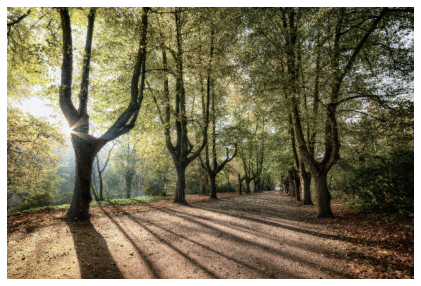

In [19]:
show_image_tensors(content_image_tensor)

In [20]:
model = create_model(opt)
model.setup(opt)
model.eval()
model.set_input({"A": A, "A_paths": ""})
model.test()
visuals = model.get_current_visuals()

initialize network with normal
model [TestModel] was created
loading the model from /home/peter/_Git/_ML/_DLSchool/dlschool-solutions/term1/project/peter/cyclegans/pytorch-CycleGAN-and-pix2pix/checkpoints/style_cezanne_pretrained/latest_net_G.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 11.378 M
-----------------------------------------------


In [21]:
styled_image_tensor = DENORMALIZE_T(visuals["fake"].cpu())

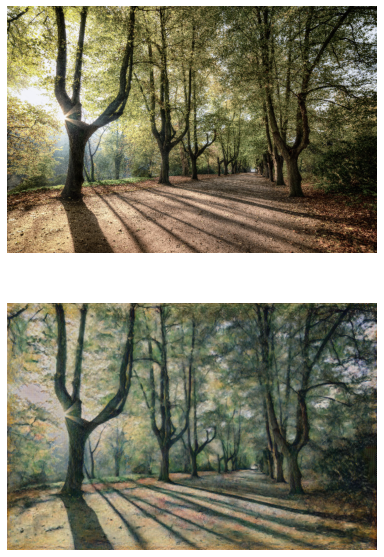

In [22]:
show_image_tensors(
    [
        DENORMALIZE_T(A),
        DENORMALIZE_T(visuals["fake"].cpu()),
    ]
)

In [23]:
save_image_tensor_to_url(styled_image_tensor[0], STYLED_IMAGE_PATH_OR_URL)